In [172]:
import pandas as pd
import numpy as np
from datetime import datetime
from sklearn.preprocessing import StandardScaler, PowerTransformer
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from sklearn.metrics import davies_bouldin_score, silhouette_score
import matplotlib.pyplot as plt

In [173]:
customers = pd.read_csv("Customers.csv")
transactions = pd.read_csv("Transactions.csv")
products = pd.read_csv("Products.csv")

In [174]:
transactions_customers = transactions.merge(customers, on="CustomerID", how="left")
full_data = transactions_customers.merge(products, on="ProductID", how="left")

In [175]:
full_data['TransactionDate'] = pd.to_datetime(full_data['TransactionDate'])

In [176]:
# Define reference date for RFM calculation
reference_date = full_data['TransactionDate'].max()

# Calculate RFM metrics
rfm = full_data.groupby('CustomerID').agg(
    Recency=('TransactionDate', lambda x: (reference_date - x.max()).days),
    Frequency=('TransactionID', 'count'),
    Monetary=('TotalValue', 'sum')
).reset_index()

In [177]:
# Add Region as a feature
rfm = rfm.merge(customers[['CustomerID', 'Region']], on='CustomerID', how='left')

# Encode Region as a numeric feature
rfm['RegionEncoded'] = rfm['Region'].astype('category').cat.codes

# Log-transform Monetary to reduce skewness (handle outliers)
rfm['Monetary'] = np.log1p(rfm['Monetary'])  # log(1 + x) for stability

# Standardize the data
features = ['Recency', 'Frequency', 'Monetary', 'RegionEncoded']
scaler = StandardScaler()
rfm_scaled = scaler.fit_transform(rfm[features])

In [178]:
kmeans = KMeans(n_clusters=4, random_state=42)
rfm['KMeans_Cluster'] = kmeans.fit_predict(rfm_pca)

# Evaluate K-Means clustering
db_index_kmeans = davies_bouldin_score(rfm_pca, rfm['KMeans_Cluster'])
silhouette_kmeans = silhouette_score(rfm_pca, rfm['KMeans_Cluster'])

print(f"K-Means - Davies-Bouldin Index: {db_index_kmeans}")
print(f"K-Means - Silhouette Score: {silhouette_kmeans}")

K-Means - Davies-Bouldin Index: 0.807697719310602
K-Means - Silhouette Score: 0.3948861169224937


In [179]:
gmm = GaussianMixture(n_components=4, random_state=42)
rfm['GMM_Cluster'] = gmm.fit_predict(rfm_pca)

# Evaluate GMM clustering
db_index_gmm = davies_bouldin_score(rfm_pca, rfm['GMM_Cluster'])
silhouette_gmm = silhouette_score(rfm_pca, rfm['GMM_Cluster'])

print(f"GMM - Davies-Bouldin Index: {db_index_gmm}")
print(f"GMM - Silhouette Score: {silhouette_gmm}")

GMM - Davies-Bouldin Index: 0.8307434919453893
GMM - Silhouette Score: 0.36857265239487164


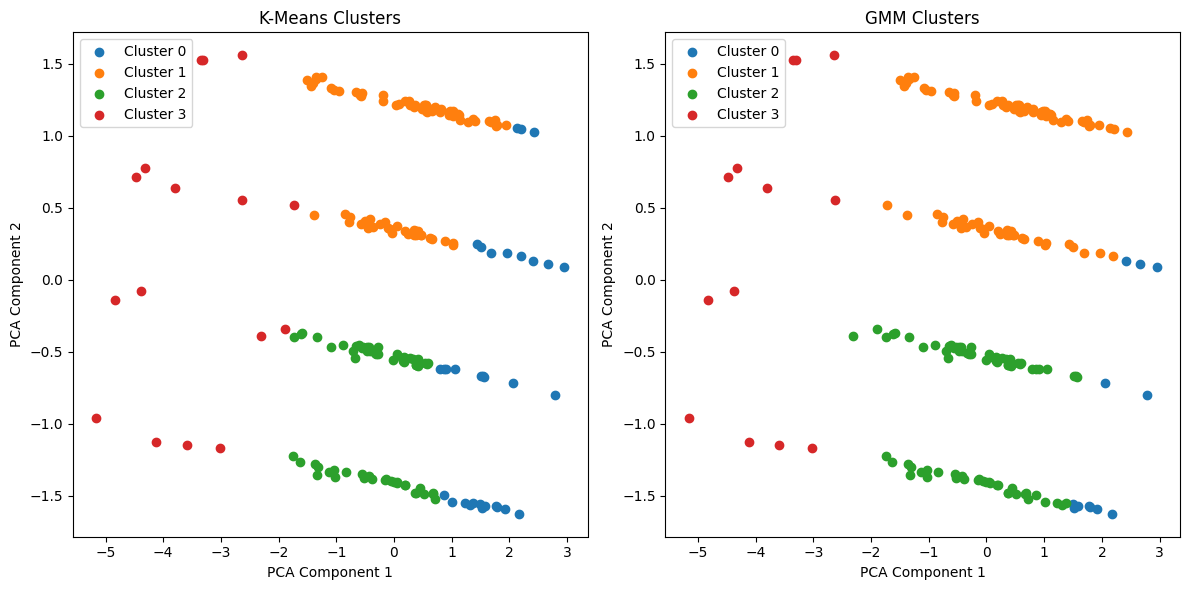

In [180]:
plt.figure(figsize=(12, 6))

# Plot K-Means Clusters
plt.subplot(1, 2, 1)
for cluster in np.unique(rfm['KMeans_Cluster']):
    cluster_data = rfm[rfm['KMeans_Cluster'] == cluster]
    plt.scatter(
        rfm_pca[cluster_data.index, 0],
        rfm_pca[cluster_data.index, 1],
        label=f'Cluster {cluster}'
    )
plt.title('K-Means Clusters')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.legend()

# Plot GMM Clusters
plt.subplot(1, 2, 2)
for cluster in np.unique(rfm['GMM_Cluster']):
    cluster_data = rfm[rfm['GMM_Cluster'] == cluster]
    plt.scatter(
        rfm_pca[cluster_data.index, 0],
        rfm_pca[cluster_data.index, 1],
        label=f'Cluster {cluster}'
    )
plt.title('GMM Clusters')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.legend()

plt.tight_layout()
plt.show()